# Part 1: tf2onnx

### Generate SavedModel from h5 (optional)
tf2onnx requires the model to be saved in SavedModel format. <br />
See https://www.tensorflow.org/guide/keras/serialization_and_saving for converting between formats for keras models.<br />
See part1_getting_started.ipynb in https://github.com/fastmachinelearning/hls4ml-tutorial for generating the example model. 

In [27]:
from tensorflow.keras.models import load_model
model = load_model("../models/hls4ml_jettag.h5")
model.save("../models/hls4ml_jettag/")

INFO:tensorflow:Assets written to: ../models/hls4ml_jettag/assets


INFO:tensorflow:Assets written to: ../models/hls4ml_jettag/assets


### Generate ONNX model from SavedModel
The following step assumes the model is saved using SavedModel format. Generate the ONNX model with a tensorflow SavedModel using tf2onnx.

In [5]:
SAVEDMODEL_PATH = "../models/hls4ml_jettag/"
ONNX_PATH = "../models/hls4ml_jettag.onnx"
!python -m tf2onnx.convert --saved-model {SAVEDMODEL_PATH} --output {ONNX_PATH}

2023-05-31 23:34:50.183023: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ruien/miniconda3/envs/o2v/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-05-31 23:34:51,219 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-05-31 23:34:51,468 - INFO - Signatures found in model: [serving_default].
2023-05-31 23:34:51,468 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-05-31 23:34:51,468 - INFO - Output names: ['softmax']
2023-05-31 23:34:51,545 - INFO - Using tensorflow=2.12.0, onnx=1.13.1, tf2onnx=1.14.0/8f8d49
2023-05-31 23:34:51,545 - INFO - Using opset <onnx, 15>
2023-05-31 23:34:51,550 - INFO - Computed 0 values for constant folding
2023-05-31 23:34:51,558 - INFO - Optimizing ONNX 

## Performance comparison

Load the dataset

In [6]:
import numpy as np

DATA_DIR = '../data/hls4ml_jettag'
X_test = np.ascontiguousarray(np.load(f'{DATA_DIR}/X_test.npy'))
Y_test = np.load(f'{DATA_DIR}/Y_test.npy', allow_pickle=True)
classes = np.load(f'{DATA_DIR}/classes.npy', allow_pickle=True)
X_test.shape, Y_test.shape, classes

((166000, 16), (166000, 5), array(['g', 'q', 't', 'w', 'z'], dtype=object))


Let's see if we lost performance after ONNX conversion by inspecting the accuracy and ROC curve.

5188/5188 [==============================] - 3s 609us/step
Keras Accuracy: 0.7646024096385542
Onnx Accuracy: 0.7646024096385542


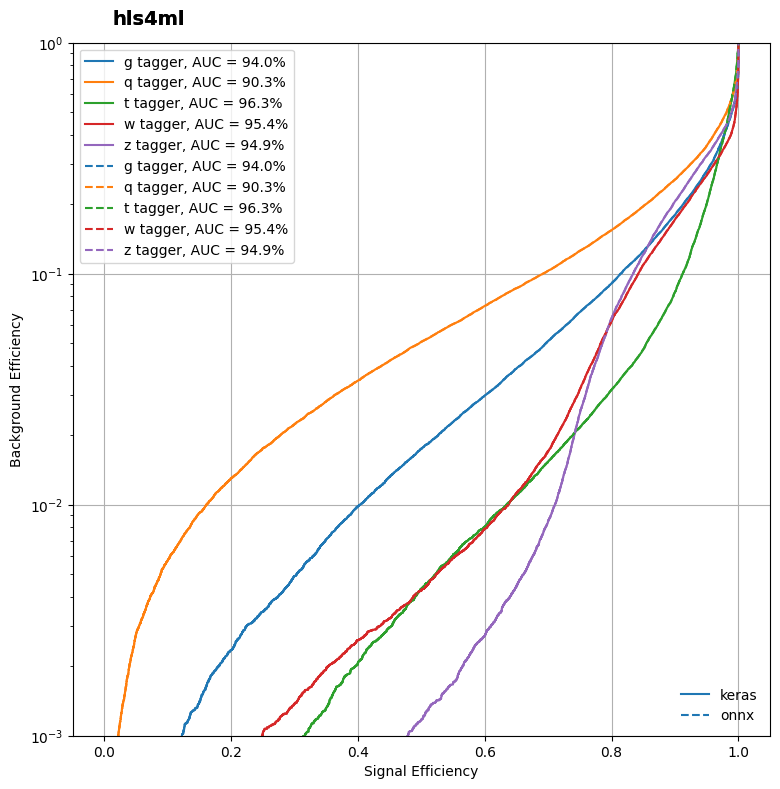

In [7]:
import plotting
import onnxruntime
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

keras_model = load_model(SAVEDMODEL_PATH)
y_keras = keras_model.predict(X_test)

ort_session = onnxruntime.InferenceSession(ONNX_PATH)
ort_inputs = {ort_session.get_inputs()[0].name: X_test.astype(np.float32)}
y_onnx = ort_session.run(None, ort_inputs)[-1]

print("Keras Accuracy: {}".format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_keras, axis=1))))
print("Onnx Accuracy: {}".format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_onnx, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(Y_test, y_keras, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(Y_test, y_onnx, classes, linestyle='--')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['keras', 'onnx'], loc='lower right', frameon=False)
ax.add_artist(leg)